## 在qemu 6.2 测试不同脏页速率converge


统计代码如下:

In [8]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re
from datetime import datetime

average_bandwidth=0
average_transfered_page=0
begin_time=0
end_time=0

def get_pattern_result(pattern,text):
    # 定义正则表达式模式
    # 使用 re.findall() 提取匹配的内容

    if re.search(pattern, text):
        matches = re.findall(pattern, text)
        # 提取结果
        return [match for group in matches for match in group if match] 
def get_every_line_from_file(filename,pattern):
    result = []
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            # 去除行末的换行符
            line = line.rstrip()
            # 打印行号和每一行
            one_result=get_pattern_result(pattern,line)
            if one_result:
                result.append(get_pattern_result(pattern,line))

    return result
def ts_str_to_ts_float(timestamp_str):
    timestamp = []
    for date_time_str in timestamp_str:
        # 将日期时间字符串转换为 datetime 对象
        dt_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
        # 将 datetime 对象转换为 Unix 时间戳（秒级）
        timestamp_one = float(dt_obj.timestamp())
        # 将时间戳添加到数组中
        timestamp.append(timestamp_one)
    return timestamp
def calculate_average(array):
    total = sum(array)
    count = len(array)
    average = total / count
    return average

def fig_migrate_transfer_bandwidth(file_name):
    ## def get_bandwidth_transferred()
    ## 25612@1733451316.508848:migrate_transferred transferred 117415476 time_spent 104 bandwidth 1128994 switchover_bw 0 max_size 338698488
    ## (\d+\.\d+) 用来匹配 @后的小数
    ## r'@(\d+\.\d+).*?transferred (\d+).*?bandwidth (\d+)'
    ## result_migrate_transffered = get_every_line_from_file(file_name, r'@(\d+\.\d+):migrate_transferred transferred (\d+).*?bandwidth (\d+)')
    result_migrate_transffered = get_every_line_from_file(file_name, r"\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{6})\] migrate_transferredtransferred (\d+).*?bandwidth (\d+)")
    timestamp_str=[row[0] for row in result_migrate_transffered]

    ts_transffered=ts_str_to_ts_float(timestamp_str)
    
    bandwidth=[row[2] for row in result_migrate_transffered]
    result_migrate_pending_estimate = get_every_line_from_file(file_name, r"\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{6})\] migrate_pendingpending size (\d+).*?")
    timestamp_str=[row[0] for row in result_migrate_pending_estimate]
    ts_pending=ts_str_to_ts_float(timestamp_str)
    remains=[row[1] for row in result_migrate_pending_estimate]
    
    array=np.array(remains)
    int_array = array.astype(int)
    diff=np.diff(int_array)
    
    transfer_pages=-diff
    transfer_pages=transfer_pages / 5
    transfer_pages=transfer_pages.astype(float)
    transfer_pages[transfer_pages <= 0] = np.nan

    begin_time=ts_transffered[0]
    end_time=ts_transffered[-1]
    total_time=end_time-begin_time;
    print("begin_time",begin_time, "\nend_time :", end_time, "\ntotal_time: ", total_time)
    
    print("average transfer_pages: ", np.nanmean(transfer_pages))
    np_bandwidth=np.array(bandwidth)
    np_bandwidth_f = np_bandwidth.astype(float)
 
    print("average bandwidth: ", np.nanmean(np_bandwidth_f))
    # print("bandwidth arr size: ", len(ts_transffered) * 1.02)
    # print("pending arr size: ", len(ts_pending) * 1.02)
    bandwidth_trace = go.Scatter(
        x=ts_transffered,  
        y=bandwidth, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="bandwidth",
        yaxis='y1'
    )  
    transfer_pages_trace = go.Scatter(
        x=ts_transffered,  
        y=transfer_pages, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="transfer_pages * 2",
        yaxis='y2',
        connectgaps=True
    )
    pending_trace = go.Scatter(
        x=ts_pending,  
        y=remains, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="remains",
        yaxis='y3'
    )
    
    return [bandwidth_trace, transfer_pages_trace, pending_trace]
def get_fig():
    fig = go.Figure(
            layout={
                "template": "xgridoff",
                "xaxis": {
                    "tickformat": '.0f'
                },
                "yaxis": {
                    # 旋转坐标字体
                    "tickangle": 0,
                    "autorange": True,
                    "tickformat": '.0f',
                    "title": "bandwidth",
                },
                "yaxis2": {
                    "overlaying" : 'y',
                    "side":'right',
                    "tickformat": '.0f',
                    "position": 0.75,
                    "title": "transfer_pages * 2",
                },
                "yaxis3": {
                    "overlaying" : 'y',
                    "side":'right',
                    "tickformat": '.0f',
                    "position": 1,
                    "title": "remains",
                },
                "height": 500,
                
            }
        )
    return fig

def show_b_tp(file_name):
    all_trace=fig_migrate_transfer_bandwidth(file_name)
    fig=get_fig()
    fig.add_trace(all_trace[0])
    fig.add_trace(all_trace[1])
    fig.show()

def show_b_tp_pend(file_name):
    all_trace=fig_migrate_transfer_bandwidth(file_name)
    fig=get_fig()
    fig.add_trace(all_trace[0])
    fig.add_trace(all_trace[1])
    fig.add_trace(all_trace[2])
    fig.show()

begin_time 1733701652.884038 
end_time : 1733701950.697191 
total_time:  297.81315302848816
average transfer_pages:  124752080.25622979
average bandwidth:  11686056.964899713


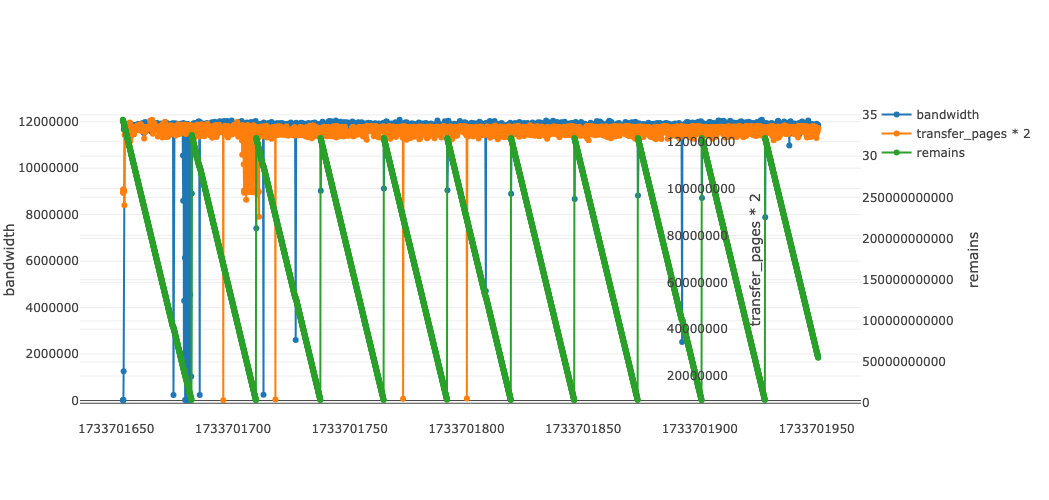

In [9]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_1200.log")

### 1100

begin_time 1733702144.8665 
end_time : 1733702442.703127 
total_time:  297.83662700653076
average transfer_pages:  123451264.73374361
average bandwidth:  11785427.678245613


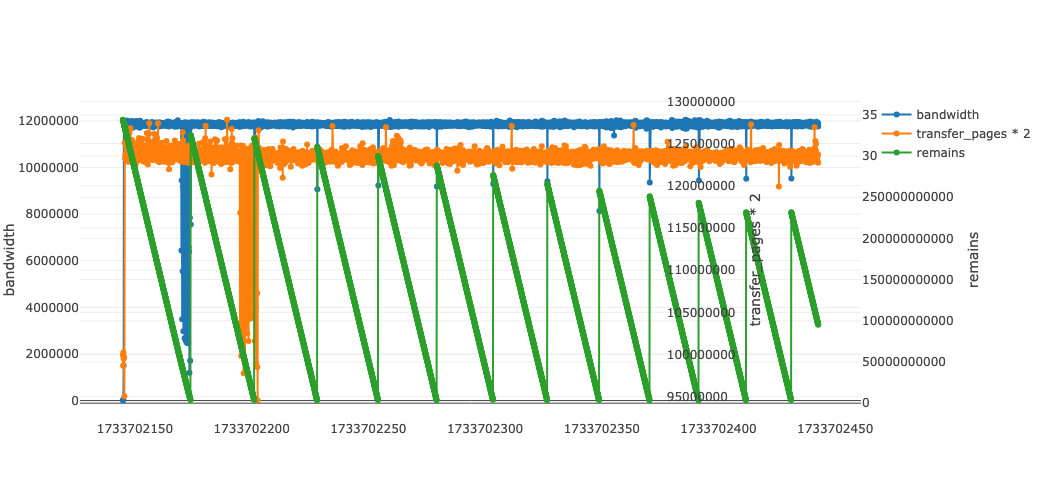

In [3]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_1100.log")

1100 有converge的趋势。但是converge时间较长。
### 1000

begin_time 1733703107.192483 
end_time : 1733703363.103671 
total_time:  255.91118812561035
average transfer_pages:  124463438.64720315
average bandwidth:  11753002.665429043


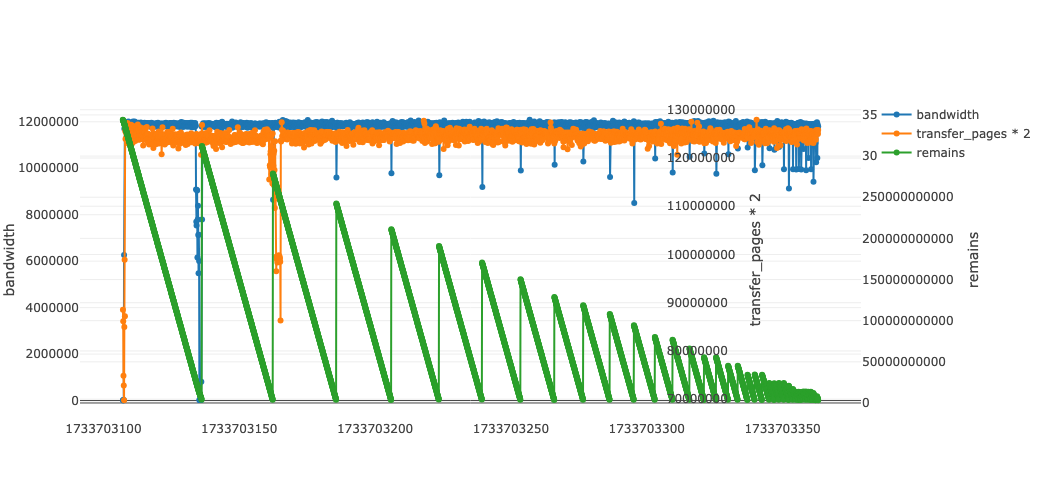

In [4]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_1000.log")

### 700

begin_time 1733704302.008267 
end_time : 1733704379.543672 
total_time:  77.53540515899658
average transfer_pages:  123874309.59562841
average bandwidth:  11566792.164179105


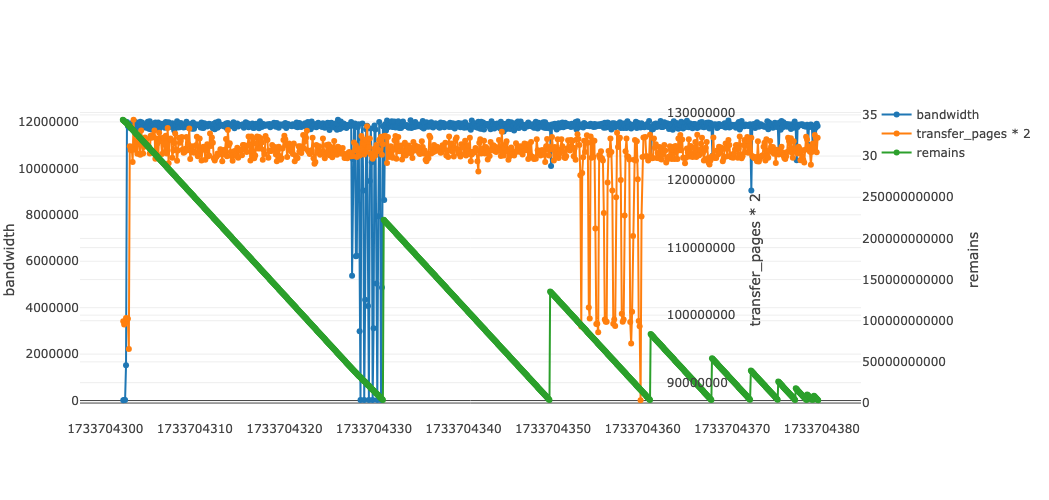

In [5]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_700.log")

### 600

begin_time 1733704414.789465 
end_time : 1733704477.407369 
total_time:  62.6179039478302
average transfer_pages:  123127577.38487396
average bandwidth:  11517470.762938231


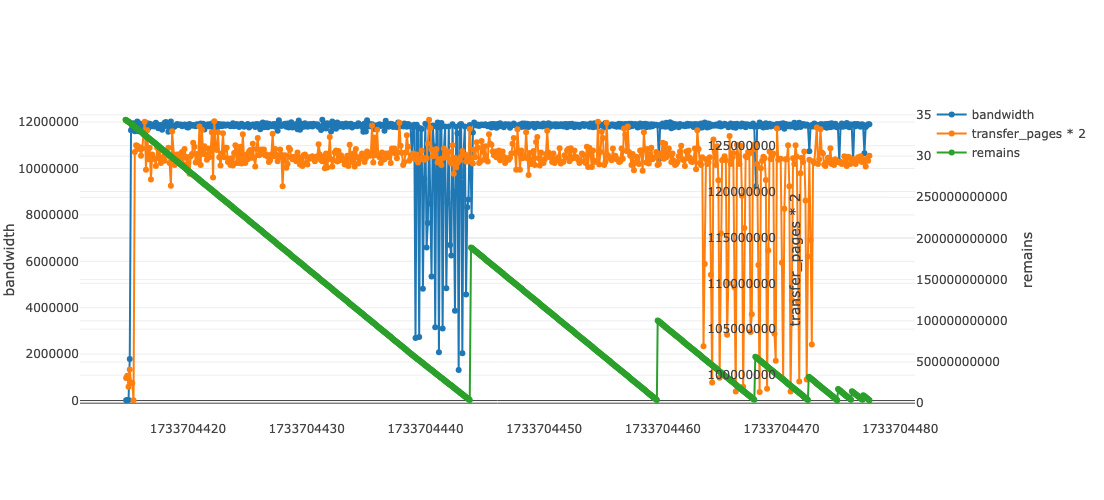

In [6]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_600.log")

### 500

begin_time 1733704512.604541 
end_time : 1733704565.129937 
total_time:  52.52539587020874
average transfer_pages:  123051651.072
average bandwidth:  11463119.290258449


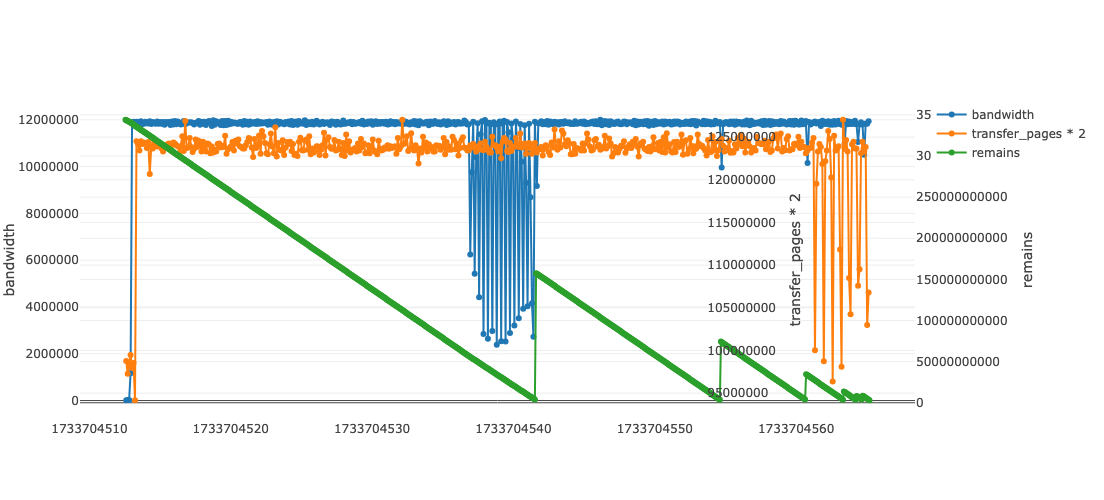

In [7]:
show_b_tp_pend("downtime_300/qemu_log_dir/rate_500.log")